# Optimisation

## Overview

 > We should forget about small efficiencies, say about 97% of the time: premature optimization is the root of all evil. ~Donald Knuth

Once we're sure we need to optimize we need to know where to focus our efforts. As with many languages your first guess should be loops, these can be even more expensive than in other languages. 

We can be a bit more scientific about this though:
 * First find where the problem is using a profiler
 * Then use the `timeit` module to test improved implementations

Once we've located the bottleneck there are a few strategies available to us to speed it up:
 * Move loops and heavy processing to specialised libraries (numpy, scipy, etc)
 * Multiprocessing / threading
 * More involved options: mpi4py, numba, cython, …

We'll cover the profiler later, but the timeit module is easy, and it's even easier to use in a notebook...

## Example 1

Consider the collocation of the satellite data onto a ground station dataset. We have lots of satellite files and want to find all of the retrievals which are near to the ground station.

In [ ]:
import cis
import numpy as np

In [ ]:
aeronet_aot_500 = cis.read_data("../resources/WorkshopData2016/Aeronet/920801_150530_Brussels.lev20", "AOT_500")

def collocate_satellite_swath_with_aeronet(swath):
    return swath.collocated_onto(aeronet_aot_500, h_sep=100)

In [ ]:
files = ["../resources/WorkshopData2016/AerosolCCI/20080411002335-ESACCI-L2P_AEROSOL-AER_PRODUCTS-AATSR-ENVISAT-ORAC_31962-fv03.04.nc",
         "../resources/WorkshopData2016/AerosolCCI/20080411020411-ESACCI-L2P_AEROSOL-AER_PRODUCTS-AATSR-ENVISAT-ORAC_31963-fv03.04.nc",
         "../resources/WorkshopData2016/AerosolCCI/20080411034447-ESACCI-L2P_AEROSOL-AER_PRODUCTS-AATSR-ENVISAT-ORAC_31964-fv03.04.nc",
         "../resources/WorkshopData2016/AerosolCCI/20080411052523-ESACCI-L2P_AEROSOL-AER_PRODUCTS-AATSR-ENVISAT-ORAC_31965-fv03.04.nc",
         "../resources/WorkshopData2016/AerosolCCI/20080411070559-ESACCI-L2P_AEROSOL-AER_PRODUCTS-AATSR-ENVISAT-ORAC_31966-fv03.04.nc"]

aerosol_cci_swaths = [cis.read_data(f, 'AOD550') for f in files]

In [ ]:
%%timeit -n1 -r1

for s in aerosol_cci_swaths:
    c = collocate_satellite_swath_with_aeronet(s)

Which is OK, but we can do better. When working with multiple independant datasets like this parallelisation can be a real help.

Parallelisation in Python couldn't be much easier. The `multiprocessing` library contains everything we need.

In [ ]:
import multiprocessing
print(multiprocessing.cpu_count())

In [ ]:
pool = multiprocessing.Pool()

Now, if we process our loop with the multiprocessing pool instead the job will automatically be mapped across as many processors as we have:

In [ ]:
%%timeit -n1 -r1

cols = pool.map(collocate_satellite_swath_with_aeronet, aerosol_cci_swaths)

## Example 2

This time consider our model dataset. We want to calculate the global mean at every timestep so we loop over each time step and use the `mean` method.

In [ ]:
def slow_function():
    d = cis.read_data("../resources/WorkshopData2016/od550aer.nc", "od550aer")
    global_means = []
    for t in d.slices_over('time'):
        global_means.append(t.data.mean())
    return global_means

In [ ]:
%%timeit
slow_function()

Again, I'm sure we could do better! Perhaps parallelisation will help again

In [ ]:
def calc_mean(cube):
    return cube.data.mean()

In [ ]:
def parallel_function():
    d = cis.read_data("../resources/WorkshopData2016/od550aer.nc", "od550aer")
    global_means = pool.map(calc_mean, d.slices_over('time'))
    return global_means

In [ ]:
%%timeit
parallel_function()

Which isn't much better. If we rethink our problem though, we realise that actually we can use the built-in `collapsed` method to do this for us.

In [ ]:
def faster_function():
    d = cis.read_data("../resources/WorkshopData2016/od550aer.nc", "od550aer")
    return d.collapsed(['x','y'], how='mean')

In [ ]:
%%timeit
faster_function()

## Other options

### MPI4Py

MPI for Python is a set of bindings to allow MPI calls directly from Python.

This allows multi-processor, multi-node operations, with full message passing in pure Python. It can even pass chunks of Numpy arrays.

```python
from mpi4py import MPI

comm = MPI.COMM_WORLD
rank = comm.Get_rank()

if rank == 0:
    data = {'a': 7, 'b': 3.14}
    comm.send(data, dest=1, tag=11)
elif rank == 1:
    data = comm.recv(source=0, tag=11)
```

For more details see http://pythonhosted.org/mpi4py/

### numba

The `numba` library provides the ability to compile arbitrary sections of code 'just-in-time'. In certain circumstances this will produce much faster run-times.

```python
from numba import jit
from numpy import arange

# jit decorator tells Numba to compile this function.
# The argument types will be inferred by Numba when function is called.
@jit
def sum2d(arr):
    M, N = arr.shape
    result = 0.0
    for i in range(M):
        for j in range(N):
            result += arr[i,j]
    return result

a = arange(9).reshape(3,3)
print(sum2d(a))
```

For more details see http://numba.pydata.org

### Cython

Cython is an optimising static compiler for Python and makes writing C extensions for Python very easy. It also enables easy wrapping of C modules.

You can write normal Python and have it compiled, or use a set of annotations to tell Cython, for example, what types the data should be.

```python
def f(x):
    return x**2-x

def integrate_f(a, b, N):
    s = 0
    dx = (b-a)/N
    for i in range(N):
        s += f(a+i*dx)
    return s * dx
```

```python 
def f(double x):
    return x**2-x

def integrate_f(double a, double b, int N):
    cdef int i
    cdef double s, dx
    s = 0
    dx = (b-a)/N
    for i in range(N):
        s += f(a+i*dx)
    return s * dx
```

For more details see http://cython.org

## Example 3

Consider the Aerosol CCI satellite data we saw yesterday. Subsetting this to lat/lon boxes was straightforward using CIS, but what if we wanted a more complex region?

In [ ]:
import shapely
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
% matplotlib inline

In [ ]:
from shapely.geometry import box
from shapely.ops import unary_union

In [3]:
northern_africa = box(-20, 0, 50, 40)
southern_africa = box(10, -40, 50, 0)
combined_africa = unary_union([northern_africa, southern_africa])
all_africa = box(-20, -40, 50, 40)

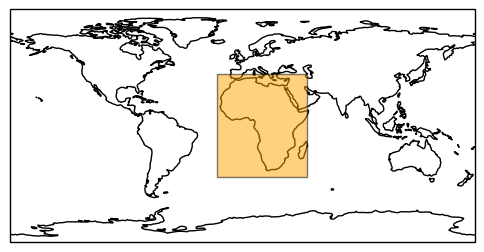

In [4]:
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.set_global()
ax.add_geometries([all_africa], ccrs.PlateCarree(), facecolor='orange', edgecolor='black', alpha=0.5)

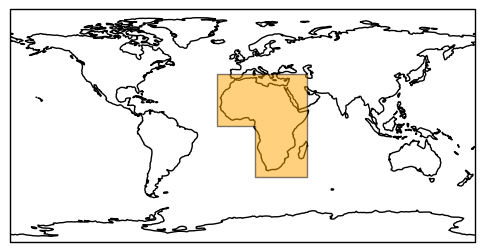

In [5]:
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.set_global()
ax.add_geometries([combined_africa], ccrs.PlateCarree(), facecolor='orange', edgecolor='black', alpha=0.5)